## Multi-label classification

### Workflow notes from [fast.ai forums](http://forums.fast.ai/t/precompute-true/7316/50)


#### 0. The default values (unless specified otherwise)
   
   bs (batch size) = 64
   precompute = False
   

#### 1. Setup your variables

   PATH = "data/dogscats/"; arch=resnet34; sz = 224

   bs=64 (batch size) is the default value in methods used below, so you don’t need to define it here.

#### 2. Setup your data augmentation (DA)

    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

The DA of your training images will have an impact only if precompute=False in your new model (learn) but if you define your DA now (thanks to aug_tfms), you will not need to take care of it after (ie, when you will run learn.precompute=False, cf point 6).

#### 3. Format your data

    data = ImageClassifierData.from_paths(PATH, tfms=tfms)

At this point, your data (images) are formatted according to your pre-trained model (arch) and preferences (sz, DA, zoom), and they are ready-to-be used.

#### 4. Setup your new neural network (NN)

    learn = ConvLearner.pretrained(arch, data, precompute=True)

The pretrained method creates your new NN from the arch model :

    -  By keeping all layers but the last one (ie, the output one which gives probabilities within 1000 classes ImageNet)
    -  Which is remplaced by adding few layers (@jeremy will give details later in the course I think) that end with an output layer which gives probabilities within 2 classes (dogs, cats).

At its creation (ie, when you run the code above : learn = ...) and by default, the new NN freezes the first layers (the ones from arch) and downloads the pre-trained weights of arch.
More, precompute=False by default. Therefore, you must precise precompute=True if you want to change the default behavior.

**What does precompute=True ?**
It tells your new NN learn to process only one time your data (images) through the arch model (but its last layer that was removed) using its pre-trained weights. That’s what we mean by the expression “compute the activations”. This transformation by activation of your data is done only one time and now the new values of your data can be used as inputs of the last layers of your new NN that you are about to train (cf point 5).

**Note 1 :** Even if you have put on the data augmentation (cf aug_tfms in point 2), this has no impact when precompute=True as the activation of your data (images) is computed only one time. So, at each new epoch used in the training, the values used as inputs of the last layers of your new NN are the ones computed at the first epoch.

**Note 2 :** There is no obligation to set precompute=True but the training of your new NN will be faster as your data (images) are processed only one time through the first layers. Therefore, it is interessing when you start your project.

#### 5. Train the last layers of your new NN

    learn.fit(0.01,1)

Through lr_find(), you choose the best learning rate and then, train your NN using the fit method (use 1 to 3 epochs). At this point (precompute=True and first layers frozen), only the last layers of your new NN will be trained (ie, their weights will be updated in order to minimize the loss of the model).

#### 6. Improve the weights of your last layers by data augmentation and SGDR

    learn.precompute=False

The more data you have, the better model you will get. Set precompute=False and then, at each new epoch used in the training of your new NN, the activation of your augmented data (cf point 2) will be computed. As well, you should use the stochastic gradient descent with restarts (SGDR) at this point.

#### 7. Improve your new NN (all layers)

    learn.unfreeze()

At this point, only your last layers have been trained. Then, you should trained now all the layers of your new NN together. This is done by setting unfreeze the first layers of learn.

**Note :** before to train again your model (using fit), you should use the lr_find() method again in order to select the best learning rate of your NN with all layers unfrozen. As well, you should use the differential learning rates and cycle_mult parameter.

#### 8. Final steps : increase sz and move to a better pre-trained model


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [11]:
PATH = 'data/Kaggle-planet/'
!pwd

/Users/akshaychougule/codebase/Git_root/fastai/courses/dl1


In [81]:
# Data in real-world is less likely to be similar wit ImageNet. One image can contain multiple categories. 
# That is why this assignment is very important.

In [12]:
ls {PATH}

test-jpg/         test-jpg.tar.7z   train-jpg.tar     train_v2.csv
test-jpg.tar      train-jpg/        train-jpg.tar.7z


## Multi-label versus single-label classification

In [8]:
from fastai.plots import *

In [9]:
# Get one example/sample from the the given directory
def get_1st(path): return glob(f'{path}/*.*')[0]

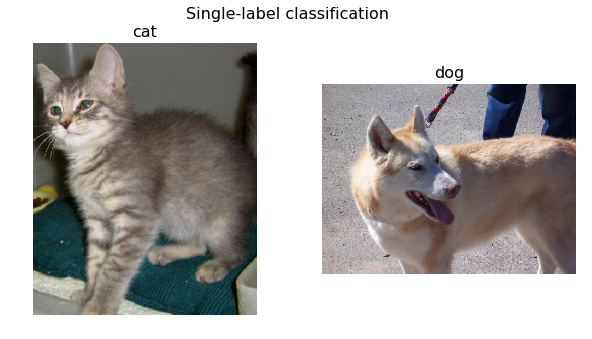

In [14]:
# Get one example each from previous lesson data repo
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

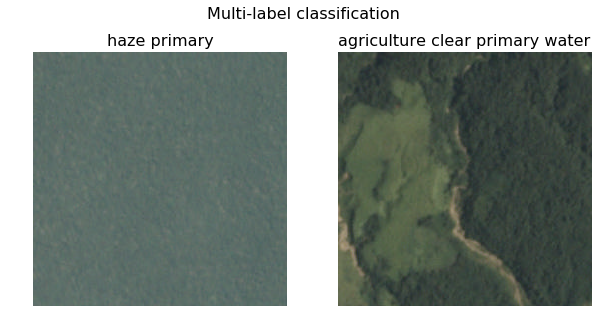

In [18]:
# Get first two examples from current train data repo
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [20]:
from planet import f2
# set how we are going to evaluate the models on training data, in this case f2 measure
metrics=[f2]
# Select a pre-trained model
f_model = resnet34

In [26]:
# Path to a file containing labelled data
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [27]:
def get_data(sz):
    # define the data augmentations/transformation
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    # get the transformed data from PATH and labels from csv file
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [28]:
# Get 256 images
data = get_data(256)

In [31]:
# How the data object looks like
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aug_dl',
 'bs',
 'c',
 'classes',
 'fix_dl',
 'from_arrays',
 'from_csv',
 'from_dls',
 'from_names_and_array',
 'from_paths',
 'get_dl',
 'get_ds',
 'is_multi',
 'is_reg',
 'num_workers',
 'path',
 'resize',
 'resized',
 'sz',
 'test_aug_dl',
 'test_dl',
 'test_ds',
 'trn_dl',
 'trn_ds',
 'trn_y',
 'val_dl',
 'val_ds',
 'val_y']

In [70]:
data.bs

64

In [71]:
# data loader function from PyTorch - it actually loads a minibatch into X and Y based on the sz, get_data
# the next(iter()) gives the next mini-batch everytime we call this function
x,y = next(iter(data.val_dl))

In [34]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [67]:
y.shape

# There are 17 possible labels
# The default batch size is 64 unless you specify otherwise in tfms in get_data

torch.Size([64, 17])

In [68]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [69]:
# Let's zip the data classed and first training example labels together
# zip is like a cbind() in R
list(zip(data.classes, y[0]))
# What we see below is called one-hot encoding

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

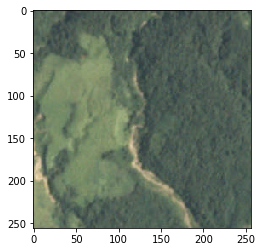

In [37]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [82]:
# Our data looks a lot less like the pre-trained model we are using
# So it is a good idea to start with small size like 64

In [83]:
sz=64

In [84]:
data = get_data(sz)

If we use precompute = True, than freeze / unfreeze do not work as we operate only on already calculated outputs of conv layers and also data augmentation do not work

In order to use data augmentation and fine tune conv layers we need to start with precompute=False in this case by default all conv layers are freezed


In [85]:
data = data.resize(int(sz*1.3), 'tmp')

In [86]:
# Build the model
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.229604   0.340207   0.832476  



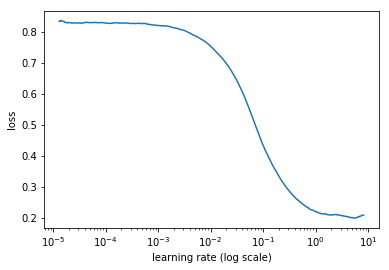

In [87]:
# Find out what learning rate to use
lrf=learn.lr_find()
learn.sched.plot()

In [89]:
# Based on the output graph of lr_find above we choose a learning rate. 
# NOTE: It should not be lr value with least loss but slightly higher than that
lr = 0.2

In [90]:
# Do some fitting for last layer untill it starts to flatten out
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
# The cycle_len and cycle_mult parameters are used for doing a variation on stochastic gradient descent 
# called “stochastic gradient descent with restarts” (SGDR).

epoch      trn_loss   val_loss   f2                          
    0      0.149572   0.134892   0.882315  
    1      0.139276   0.128958   0.888699                    
    2      0.134892   0.127183   0.889365                    
    3      0.137176   0.126844   0.889084                    
    4      0.135511   0.123551   0.89386                     
    5      0.132838   0.122966   0.893255                    
    6      0.129101   0.122841   0.893935                    



[array([0.12284]), 0.8939351086439773]

In [93]:
learn.fit??

In [96]:
# Now we are going to unfreeze the layer and train the model
# As there is more reusable information in initial layer, we choose a smaller lr value and gradually increase it
lrs = np.array([lr/9,lr/3,lr])
# The first value of lr is used for first half of NN, the second value is used for second half except last layer
# The third lr value is used for last layer.

The cycle_len and cycle_mult parameters are used for doing a variation on stochastic gradient descent called “stochastic gradient descent with restarts” (SGDR).

The idea is to start doing our usual minibatch gradient descent with a given learning rate (lr), while gradually decreasing it (the fast.ai1 library uses “cosine annealing”)… until we jump it back up to lr!

The cycle_len parameter governs how long we’re going to ride that cosine curve as we decrease… decrease… decrease… the learning rate. Cycles are measured in epochs, so cycle_len=1 by itself would mean to continually decrease the learning rate over the course of one epoch, and then jump it back up. The cycle_mult parameter says to multiply the length of a cycle by something (in this case, 2) as soon as you finish one.

So, here we’re going to do three cycles, of lengths (in epochs): 1, 2, and 4. So, 7 epochs in total, but our SGDR only restarts twice.

In [101]:
# Unfreezing the layers
learn.unfreeze()

# Now we are using lrs - differential learning rate
#learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.fit(lrs,1, cycle_len=1)
# lrs (float or list(float)): learning rate for the model
# n_cycle (int): number of cycles (or iterations) to fit the model for
# wds (float or list(float)): weight decay parameter(s)

epoch      trn_loss   val_loss   f2                          
    0      0.121164   0.108912   0.906907  


[array([0.10891]), 0.9069069996008945]

In [97]:
# What does learn.save does?
learn.save(f'{sz}')
# learn.save() method saves the model in .h5 format. 
# Is there a way to save the model in .pth format (PyTorch)?

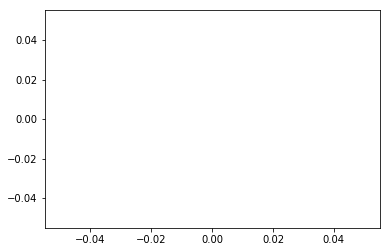

In [98]:
learn.sched.plot_loss()

In [20]:
sz=128

In [21]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [26]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [27]:
f2(preds,y)

0.93626519738612801

### End